# Building and Evaluating Wrist Motion Classifier

In [20]:
# Import necessary modules
import os
import zipfile

import pandas as pd
import numpy as np
import statistics
import random

import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn machine learning
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


# evaluate model performance
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss



In [2]:
import sklearn

estimators = sklearn.utils.all_estimators(type_filter=None)
for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HalvingGridSearchCV
HalvingRandomSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


In [ ]:
# # test from-the-box scikit-learn classifier algs to establish baseline performance estimates

# from lazypredict.Supervised import LazyClassifier

In [ ]:
# # import imblearn libraries for SMOTETomek
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import TomekLinks
# from imblearn.combine import SMOTETomek

In [3]:
# Import the data
df = pd.read_csv('./interim/pison_data.csv', header=0)
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.head()  

,timestamp,channel_0,channel_1,channel_0_hp,channel_1_hp,q_x,q_y,q_z,q_w,g_x,g_y,g_z,a_x,a_y,a_z,body_movement,repetition
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


## Preprocessing the Data

In [5]:
df.rename(columns={'repetition': 'target'}, inplace=True)

In [6]:
df.head()

,timestamp,channel_0,channel_1,channel_0_hp,channel_1_hp,q_x,q_y,q_z,q_w,g_x,g_y,g_z,a_x,a_y,a_z,body_movement,target
0,1514824.503,12535249,12566283,-11889,17295,0.32196,-0.596619,-0.621826,0.392090,-1.342870,1.063105,0.503576,-0.660156,-10.003906,1.21875,0,1
1,1514827.496,12536264,12559246,-2063,13384,0.32196,-0.596741,-0.621826,0.392029,-1.510729,1.175011,0.000000,-0.660156,-10.003906,1.21875,0,1
2,1514830.493,12538584,12565279,2757,16008,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
3,1514833.500,12546745,12567024,7504,5644,0.32196,-0.596741,-0.621765,0.391968,-1.230964,1.175011,-0.279765,-0.660156,-10.003906,1.21875,0,1
4,1514836.498,12537375,12545467,-3855,-15893,0.32196,-0.596802,-0.621765,0.391907,-1.063105,0.839294,-0.727388,-0.660156,-10.003906,1.21875,0,1


In [7]:
df.shape

(14981, 17)

In [ ]:
# also do not use the timestamp

### Create Train/Test Split

In [8]:
# define X and y

X = df.iloc[:, 1:15]  # features, excluding timestamp column
y = df.target  # target variable

feature_list = list(X.columns)

# 80:20 :: test:train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=420)



Can try a different split (70:30)

In [9]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled=scaler.transform(X_test)
X_test_scaled = scaler.transform(X_test)

Fitting the scaler on only the training data prevents data leakage between your model training and model validation. We don't have a validation set here, but this is still best practice.

## Train and Fit Classifier Models

### Random Forest Classifier

In [10]:
# Random Forest Classifier
# Model 1
# 

clf = RandomForestClassifier(n_estimators = 500, random_state=420, n_jobs=-1)

model1 = clf.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_test_scaled)
y_pred_prob = model1.predict_proba(X_test_scaled)


train_ac = accuracy_score(y_train, clf.predict(X_train))
test_ac = accuracy_score(y_test, y_pred)  # test accuracy

f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest: Train Accuracy=%.3f' % (train_ac))
print('Random Forest: Test Accuracy=%.3f' % (test_ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Train Accuracy=0.357
Random Forest: Test Accuracy=1.000
Random Forest: f1-score=1.000


In [11]:
y_test.value_counts()  # class distribution in test set is similar to that of train set

2    1005
1    1000
3     992
Name: target, dtype: int64

### Evaluate Model Performance

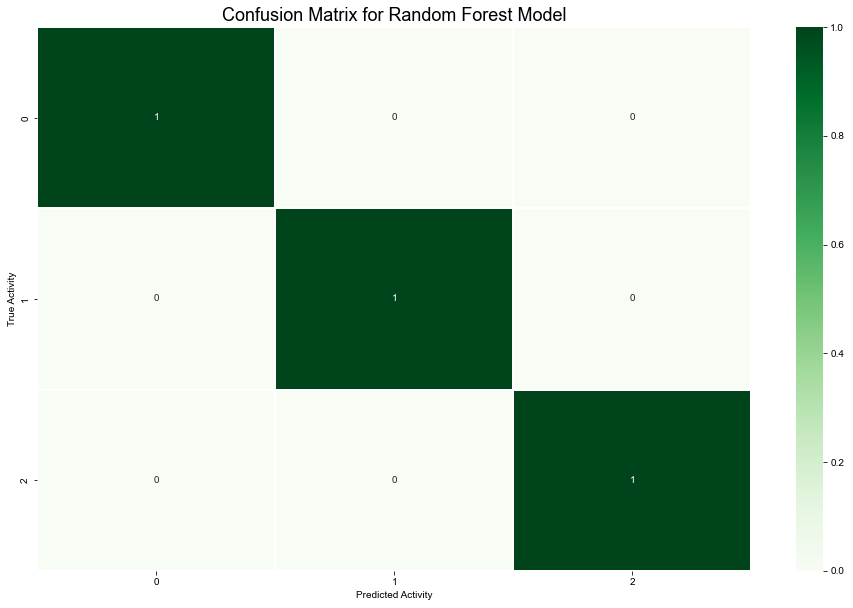

In [12]:
conf = confusion_matrix(y_test, y_pred).astype('float')
conf = conf / conf.sum(axis=1)[:, np.newaxis]

#plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(conf, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
sns.set(font_scale=1.5)

_ = plt.xlabel('Predicted Activity')
_ = plt.ylabel('True Activity')
_ = plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1005
           3       1.00      1.00      1.00       992

    accuracy                           1.00      2997
   macro avg       1.00      1.00      1.00      2997
weighted avg       1.00      1.00      1.00      2997



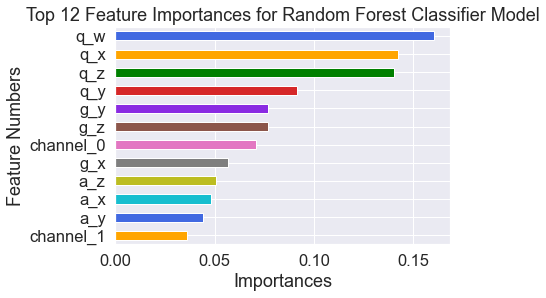

In [14]:
# feature importances for Model 1 (Random Forest Classifier)

feature_importances = pd.Series(model1.feature_importances_, index=feature_list)
_ = feature_importances.nlargest(12).plot(kind='barh', color=['royalblue', 'orange', 'green', 'tab:red', 'blueviolet', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']).invert_yaxis()

_ = plt.ylabel('Feature Numbers')
_ = plt.xlabel('Importances')
_ = plt.title('Top 12 Feature Importances for Random Forest Classifier Model')
plt.show()

### Random Forest Classifier 2

There was a big difference in the train accuracy and test accuracy. The train accuracy was very low and the test accuracy was perfect. Why? 

**Can try new strategy here:**

Test on walking fast whole body movement.
Train on all other whole body movements.

In [ ]:
# # create train/test/validation split using new strategy

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=420)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 2/7, random_state=420)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

### Linear Support Vector Classifier

In [31]:
# use LinearSVC because better scaling than SVC (linear scaling vs quadratic scaling)

clf2 = LinearSVC(random_state=420)

model2 = clf2.fit(X_train_scaled, y_train)

y_pred = model2.predict(X_test_scaled)
train_ac = accuracy_score(y_train, clf2.predict(X_train_scaled))
test_ac = accuracy_score(y_test, y_pred)  # test accuracy

f1 = f1_score(y_test, y_pred, average='weighted')

print('Linear SVC: Train Accuracy=%.3f' % (train_ac))
print('Linear SVC: Test Accuracy=%.3f' % (test_ac))

Linear SVC: Train Accuracy=0.683
Linear SVC: Test Accuracy=0.655


C:\Users\shak-\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Would be helpful to mitigate overfitting, if any. 
Also helpful to increase model performance.

### Evaluate Model Performance for SVC

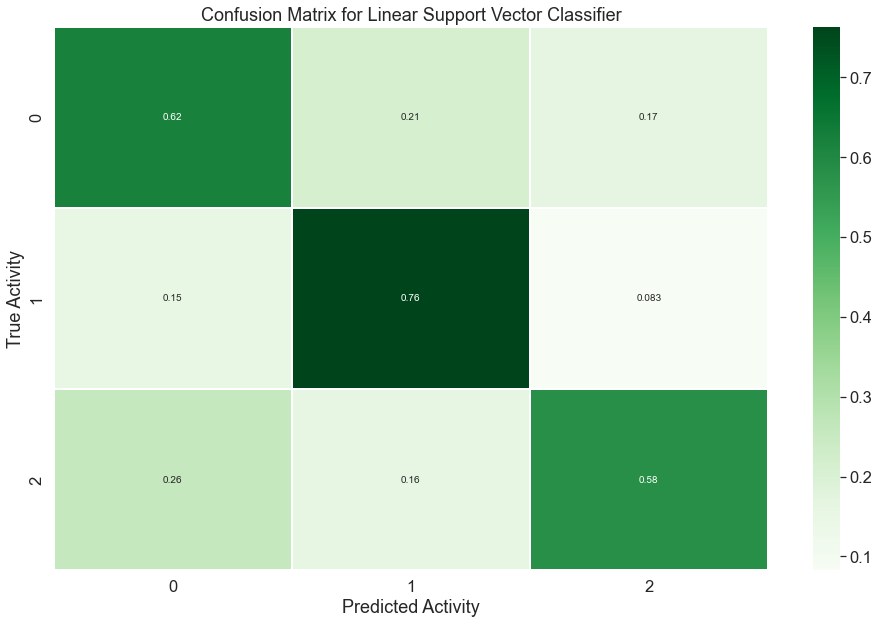

In [32]:
conf = confusion_matrix(y_test, y_pred).astype('float')
conf = conf / conf.sum(axis=1)[:, np.newaxis]

#plot confusion matrix
plt.figure(figsize=(16, 10))
sns.heatmap(conf, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
sns.set(font_scale=1.5)

_ = plt.xlabel('Predicted Activity')
_ = plt.ylabel('True Activity')
_ = plt.title('Confusion Matrix for Linear Support Vector Classifier')
plt.show()

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.62      0.61      1000
           2       0.67      0.76      0.71      1005
           3       0.70      0.58      0.63       992

    accuracy                           0.65      2997
   macro avg       0.66      0.65      0.65      2997
weighted avg       0.66      0.65      0.65      2997



## Hyperparameter Optimization